# Defining a categorical scoring system

This notebook explores how we translate a continuous system of risk values into a 11-step categorical scoring system.

In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
duckdb.sql("""INSTALL SPATIAL; LOAD SPATIAL; INSTALL HTTPFS; LOAD HTTPFS""")

In [3]:
%%time

version = '0.12.0'

dataset_uri = f's3://carbonplan-ocr/output/fire-risk/vector/production/v{version}/geoparquet/buildings.parquet/**'

df = duckdb.sql(f"""
SELECT wind_risk_2011, wind_risk_2047
FROM read_parquet('{dataset_uri}', hive_partitioning = TRUE)
""").df()

df.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 36.8 s, sys: 4.37 s, total: 41.2 s
Wall time: 2min 7s


,wind_risk_2011,wind_risk_2047
0,0.012351,0.011586
1,0.021445,0.011569
2,0.023781,0.032394
3,0.035571,0.016607
4,0.012335,0.012119


The distribution of risk values in this dataset is skewed with a very long tail at higher levels of risk. This skewed distribution can make it hard to distinguish both differences among risk levels at both higher and lower levels of risk. We overcome this, we design a scoring system with bins whose relative prevalence of buildings descend monotonically with increasing risk scores. We design the bins like this so that we can distinguish among risk values across the highly heterogeneous domain where risk values span multiple orders of magnitude.

Our approach is inspired by the WRC's increasingly fine percentile increments at higher levels of risk, as described in the supplemental materials for the Wildfire Risk to Communities project, specifically the `WRC_V2_DataPercentiles.xlsx` file found [here](https://www.fs.usda.gov/rds/archive/catalog/RDS-2020-0016-2). The WRC project uses "class breakpoints at 40th, 70th, 90th, and 95th percentile."  According to their documentation, that translates to breakpoints at the following values of RPS: `0.0188485, 0.0940430, 0.4081965, 0.7222983`. However, they based their percentiles and breakpoints on pixels as opposed to buildings, so they are in appropriate for us to use out-of-the-box. Given our focus on buildings, we will design our bins according to the distribuiton of risk values for buildings. 


We began with drafting a set of round number percentile scale breakpoints which grow increasingly close together as they near 100: `[75, 83, 88, 93, 96, 98, 99, 99.9, 99.99]`. 

In [4]:
percentiles = np.array([75, 82.5, 88, 92.5, 96, 98, 99.5, 99.9, 99.99])

We then calculate the RPS value for each of these percentiles.

In [5]:
bins = np.percentile(df[['wind_risk_2011']].values, percentiles)

In [6]:
bins = np.insert(bins, 0, 0, axis=0)
bins = np.insert(bins, 10, 100, axis=0)

All of this is probably easier shown than explained. When we use the bins calculated above to assign risk scores to the buildings in our dataset, the distribution of risk scores looks like below.

Text(0.5, 1.0, 'Counts of buildings in each score bin')

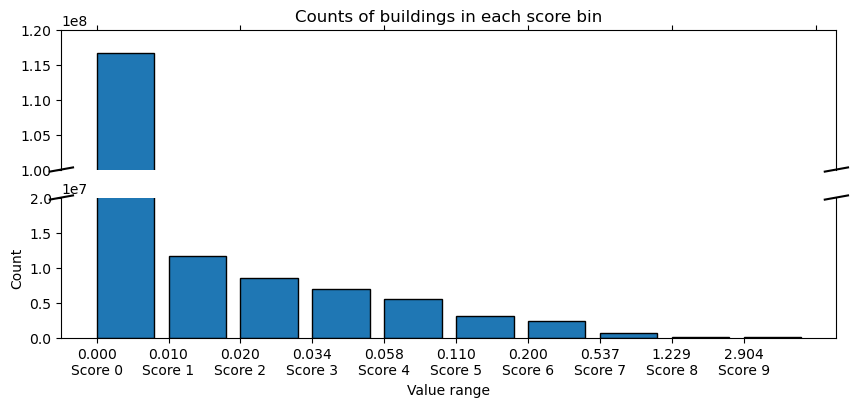

In [7]:
values = df['wind_risk_2011'].values
counts, edges = np.histogram(values, bins=bins)
x = np.arange(len(counts))
width = 0.8
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))
ax1.bar(x, counts, width=width, align='edge', edgecolor='black')
ax2.bar(x, counts, width=width, align='edge', edgecolor='black')
ax1.set_ylim(1e8, 1.2e8)  # outliers only
ax2.set_ylim(0, 0.2e8)
labels = [f'{bins[i]:.3f}\nScore {j}' for i, j in enumerate(range(len(bins) - 1))]
ax2.set_xticks(x, labels)  # , ha='right')
d = 0.015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
# plt.ylim(0,0.2e8)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlabel('Value range')
ax2.set_ylabel('Count')
ax1.set_title('Counts of buildings in each score bin')
# plt.tight_layout()
# plt.show()

Let's update the bin breakpoints to rounder numbers to support interpretability. Then, let's confirm that the rounding update still preserves general pattern of higher risk scores being less prevalent.

In [8]:
rounded_bins = [0.01, 0.02, 0.035, 0.06, 0.1, 0.2, 0.5, 1, 3]

We then assess the original percentiles from these rounded bins to ensure that the percentiles still decrease monotonically, with breakpoints that grow increasingly close together.

In [9]:
percentiles = stats.percentileofscore(df['wind_risk_2011'].values, rounded_bins)
print(percentiles)

[74.58973564 82.46095187 88.42748834 92.77648692 95.59691283 97.99944176
 99.43752461 99.84220249 99.99091753]


In [10]:
bins = rounded_bins
bins = np.insert(bins, 0, 0, axis=0)
bins = np.insert(bins, 10, 100, axis=0)

As shown below, the bin breakpoints at higher risk levels are more spaced out (and more clustered at lower risk levels), while the corresponding percentiles are more clustered at higher risk levels and more spaced out at lower risk levels.

In [11]:
print(bins)
print(percentiles)

[0.0e+00 1.0e-02 2.0e-02 3.5e-02 6.0e-02 1.0e-01 2.0e-01 5.0e-01 1.0e+00
 3.0e+00 1.0e+02]
[74.58973564 82.46095187 88.42748834 92.77648692 95.59691283 97.99944176
 99.43752461 99.84220249 99.99091753]


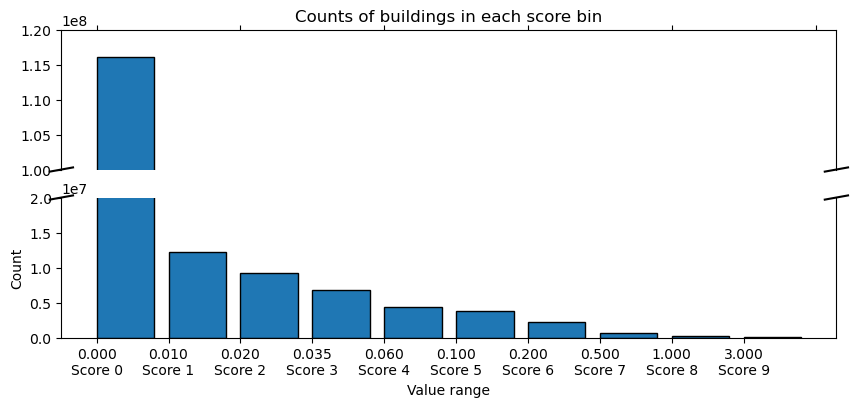

In [12]:
values = df['wind_risk_2011'].values
counts, edges = np.histogram(values, bins=bins)
x = np.arange(len(counts))
width = 0.8
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))
ax1.bar(x, counts, width=width, align='edge', edgecolor='black')
ax2.bar(x, counts, width=width, align='edge', edgecolor='black')
ax1.set_ylim(1e8, 1.2e8)  # outliers only
ax2.set_ylim(0, 0.2e8)
labels = [f'{bins[i]:.3f}\nScore {j}' for i, j in enumerate(range(len(bins) - 1))]
ax2.set_xticks(x, labels)  # , ha='right')
d = 0.015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
# plt.ylim(0,0.2e8)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlabel('Value range')
ax2.set_ylabel('Count')
ax1.set_title('Counts of buildings in each score bin')
# plt.tight_layout()
plt.show()

Then let's see what the risk values look like for the future scenario.

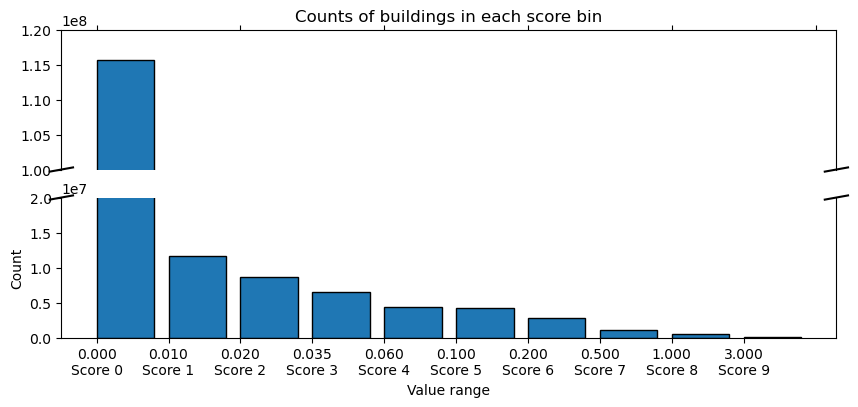

In [13]:
values = df['wind_risk_2047'].values
counts, edges = np.histogram(values, bins=bins)
x = np.arange(len(counts))
width = 0.8
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))
ax1.bar(x, counts, width=width, align='edge', edgecolor='black')
ax2.bar(x, counts, width=width, align='edge', edgecolor='black')
ax1.set_ylim(1e8, 1.2e8)  # outliers only
ax2.set_ylim(0, 0.2e8)
labels = [f'{bins[i]:.3f}\nScore {j}' for i, j in enumerate(range(len(bins) - 1))]
ax2.set_xticks(x, labels)  # , ha='right')
d = 0.015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
# plt.ylim(0,0.2e8)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlabel('Value range')
ax2.set_ylabel('Count')
ax1.set_title('Counts of buildings in each score bin')
# plt.tight_layout()
plt.show()